In [ ]:
import numpy as np
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from clebschgordan import *
from wigner3j import *
from C_jlp import *
from matplotlib import rc
from mie_coefs import *
from focused_beams_class import *
from domain_class import *
from Multipoles import *




## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

In [35]:
import numba
import scipy
import numba_scipy

print("Numba version:", numba.__version__)
print("SciPy version:", scipy.__version__)
print("Numba-Scipy version:", numba_scipy.__version__)

Numba version: 0.61.0
SciPy version: 1.15.1
Numba-Scipy version: 0.2.0


In [40]:
import numba_special


ModuleNotFoundError: No module named 'numba_special'

In [70]:
def d_jmp(j, m, p, Theta):
    M = max(abs(m), abs(p))
    N = min(abs(m), abs(p))
    
    lnCoef = 0.5 * (sp.gammaln(j - M + 1) + sp.gammaln(j + M + 1) - sp.gammaln(j + N + 1) - sp.gammaln(j - N + 1))

    cosFac = np.cos(Theta / 2) ** (abs(m + p))
    sinFac = (np.sin(Theta / 2)) ** (abs(m-p)) ## p-m? 
    
    n = j - M
    alpha = abs(m - p)
    beta = abs(m + p)
    hyp = sp.eval_jacobi(n, alpha, beta, np.cos(Theta))
    
    if hyp == 0:
        d_jmp = 0
    else:
        d_jmp = np.exp(lnCoef) * cosFac * sinFac * hyp * (-1) ** (0.5*(p-m-abs(m-p)))
    
    return d_jmp

\begin{align*}
    D_{m^{\prime}m}^j(\alpha\beta\gamma)=e^{-im^{\prime}\alpha}d_{m^{\prime}m}^j(\beta)e^{-im\gamma}
\end{align*}

In [127]:
def D_jmp(j, m, p, alpha, beta, gamma):
    fac1 = np.exp(1j * m * alpha)
    fac2 = d_jmp(j, m, p, beta)
    fac3 = np.exp(1j * p * gamma)
    return fac1 * fac2 * fac3

In [305]:
#initialize domain
size = 4
planes = {'xy', 'xz', 'yz'}
d = domain(size, planes)

wl = 0.632
jmax = 10

foc = focused_beams("LaguerreGauss", jmax, wl, d, NA=0.9, f=1000, n_lens=1)

In [306]:
foc.C_jlp(l = 0, p = 1, q = 0)

(array([ 0.00000000e+00+0.00000000e+00j, -8.59724207e-02-4.75283797e-01j,
        -6.46509638e-02-3.57411776e-01j, -4.20938555e-02-2.32708668e-01j,
        -2.39920929e-02-1.32636175e-01j, -1.25390254e-02-6.93198536e-02j,
        -6.63341162e-03-3.66716796e-02j, -3.77602428e-03-2.08751033e-02j,
        -2.01379212e-03-1.11329047e-02j, -6.86850420e-04-3.79713486e-03j,
         6.19839296e-05+3.42667534e-04j]),
 0.998439021404897,
 1.9963143289466065)

The (2j+1)Cjm_z normalization yields 1.996314
The LG integral on the aplanatic lens surface is 0.998



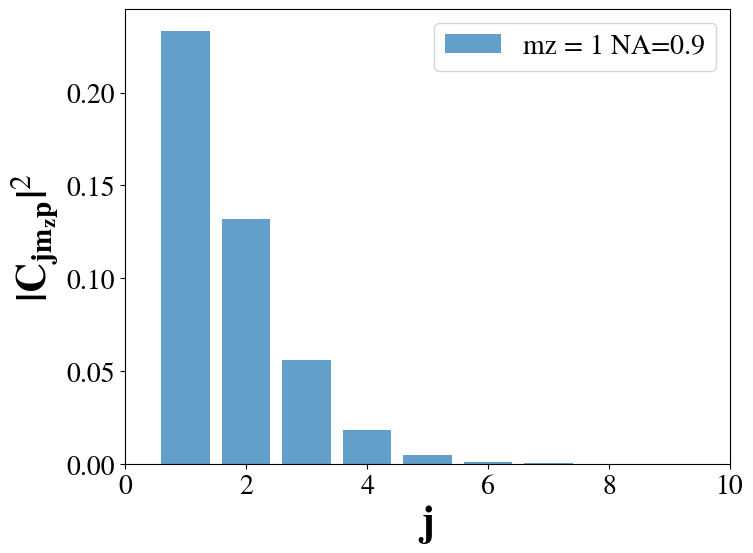

In [307]:
C_on = foc.C_jlp(l = 0, p = 1, q = 0)
foc.plot_Cjl(l = 0, p = 1, q = 0)

In [308]:
#@njit
def process_d(d):
    """ 
    Decompose d into a magnitude and two rotation angles: 
        polar (theta) and azimuthal (phi)
    Parameters:
        d: numpy array of shape (3,) specifying the cartesian coordinates
    Returns:
        d: float: magnitude of d
        theta: float: polar angle in radians
        phi: float: azimuthal angle in radians
    """
    # Check if d is a numpy array
    if not isinstance(d, np.ndarray):
        d = np.array(d)
    # Check if d has the correct shape
    if d.shape != (3,):
        raise ValueError("Input array must have shape (3,)")
    if np.linalg.norm(d) == 0:
        print("displacement is zero")
        return 0, 0, 0
    else:
        mag = np.linalg.norm(d)
        d = d / mag # normalize
        # Calculate the angles
        theta = np.arccos(d[2])
        phi = np.arctan2(d[1], d[0])
        
        return mag, theta, phi       

In [309]:
d = np.array([0, 2, 0])
m, theta, phi = process_d(d)
print(m, theta, phi)

2.0 1.5707963267948966 1.5707963267948966


In [132]:
d_jmp(2, 2, 1, theta)

-0.5000000000000001

In [727]:
D_jmp(2, 1, 0, theta, phi, 0)

(-8.326005920943603e-33-1.3597399555105182e-16j)

\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} = \sum_{n=-\min (j, j^{\prime})}^{\min (j, j^{\prime})} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
    \sum_{j^\prime=m_z^*}^\infty D^j_{m_z n}(\mathrm{\hat{d}})D^j_{m_z^* n}(\mathrm{\hat{d}}) C_{j^\prime m_z^* p}^{on}
\end{align*}

If the displacement is along z:
\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} =  \sum_{j^\prime=m_z^*}^\infty C_{j^\prime m_z^* p}^{on} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
\end{align*}

In [471]:
def get_Jl(L, x):
    return sp.spherical_jn(L, x)

In [740]:
# Store all matrices in a list
D_matrices = []

for j in range(1, 12):
    size = 2 * j + 1
    D_mat = np.zeros((size, size), dtype=complex)

    for m_idx, m in enumerate(range(-j, j + 1)):
        for n_idx, n in enumerate(range(-j, j + 1)):
            D_mat[m_idx, n_idx] = D_jmp(j, m, n, phi, theta, 0)
    
    D_matrices.append(D_mat)

In [ ]:
#@jit(nopython=True)
def compute_C_off(j_max, mz_star, p, k, d, C_on):
    """
    Compute C^off as a 2D array with:
    - j from 0 to j_max (axis 1)
    - m_z from -j_max to j_max (axis 2)

    Parameters:
    - j_max: Maximum j value
    - mz_star: Fixed m_z* value
    - p: Index p
    - k: Wavevector magnitude
    - d: Displacement vector (numpy array with shape (3,))
    - C_on: Known C^on values (1D array, indexed by j')

    Returns:
    - C_off: 2D array of shape (j_max+1, 2*j_max+1)
    """

    C_off = np.zeros((j_max + 1, 2 * j_max + 1), dtype=np.complex128)  # Initialize C_off array
    
    # Process the displacement vector into spherical coordinates
    mag, theta, phi = process_d(d)
    
    Lvals = np.arange(0, 2* j_max + 1)
    #simple case: z displacemet
    if ((d[0] == 0) and (d[1] == 0)):
        for j in range(j_max + 1):
            for m_z in range(-j_max, j_max + 1):
                sum_Ln = 0
                for L in Lvals:
                    J_L = get_Jl(L, k * mag)
                    factor = (2 * L + 1) * (-1j)**L * J_L
                    CG_1 = clebsch_gordan(j, L, j_prime, mz_star, 0, mz_star)
                    CG_2 = clebsch_gordan(j, L, j_prime, p, 0, p)
                    sum_Ln += factor * CG_1 * CG_2

                # Store result in 2D array, shifting index for m_z
                C_off[j, m_z + j_max] += sum_Ln * C_on[j_prime]
    else:       
        for j in range(1, j_max + 1):
            for m_z in range(-j_max, j_max + 1):
                for j_prime in range(max(abs(mz_star),1), j_max + 1):
                    sum_Ln = 0
                    for L in Lvals:
                        J_L = get_Jl(L, k * mag)
                        factor = (2 * L + 1) * (-1j)**L * J_L
                        for n in range(-min(j, j_prime), min(j, j_prime) + 1):
                            CG_1 = clebsch_gordan(j, L, j_prime, n, 0, n)
                            CG_2 = clebsch_gordan(j, L, j_prime, p, 0, p)
                            D1 = D_jmp(j_prime, mz_star, n, phi, theta, 0) 
                            D2 = D_jmp(j, m_z, n, phi, theta, 0)
                            sum_Ln += factor * CG_1 * CG_2 * D1 * D2
                            
                        if sum_Ln != 0:    
                            pass
                            #print("sum_Ln", sum_Ln)

                    C_off[j, m_z + j_max] += C_on[j_prime] * sum_Ln

    return C_off


In [ ]:
clebsch_gordan(2, 2, 2, 1, 0, 1)

-0.26726124191242434

In [310]:
def matrix_CGs(Lmax, jpmax, clebsch_gordan_func):
    """
    Compute CG1 and CG2 matrices for Clebsch-Gordan coefficients.
    
    Parameters:
    - Lmax: Maximum L value
    - jpmax: Maximum j' value
    - clebsch_gordan_func: Function to compute Clebsch-Gordan coefficients

    Returns:
    - CG1: 4D NumPy array with shape (jpmax+1, Lmax+1, jpmax+1, 2*min(i, j)+1)
    - CG2: 3D NumPy array with shape (jpmax+1, Lmax+1, jpmax+1)
    """
    CG1 = np.zeros((jpmax+1, Lmax+1, jpmax+1, 2*min(Lmax, jpmax)+1), dtype=np.complex128)
    CG2 = np.zeros((jpmax+1, Lmax+1, jpmax+1), dtype=np.complex128)

    for i in range(1, Lmax+1):  # Loop over i (1-based in MATLAB)
        for j in range(1, jpmax+1):  # Loop over j
            for k in range(jpmax+1):  # Loop over k
                nnk = 0  # Counter for index
                for l in range(-min(i, j), min(i, j) + 1):  # Loop over l
                    CG1[j, k, i, nnk] = clebsch_gordan_func(j, k, i, l, 0, l)
                    nnk += 1
                
                # Compute CG2 (fixed l=1)
                CG2[j, k, i] = clebsch_gordan_func(j, k, i, 1, 0, 1)

    return CG1, CG2

In [1112]:
CG1, CG2 = matrix_CGs(10, 10, clebsch_gordan)

In [1113]:
def compute_C_off(j_max, mz_star, k, d, C_on):
    """
    Compute C^off as a 2D array with:
    - j from 0 to j_max (axis 1)
    - m_z from -j_max to j_max (axis 2)

    Parameters:
    - j_max: Maximum j value
    - mz_star: Fixed m_z* value
    - p: Index p
    - k: Wavevector magnitude
    - d: Displacement vector (numpy array with shape (3,))
    - C_on: Known C^on values (1D array, indexed by j')

    Returns:
    - C_off: 2D array of shape (j_max+1, 2*j_max+1)
    """
    # Process displacement vector into spherical coordinates
    mag, theta, phi = process_d(d)
    
    D_matrices = []

    for jj in range(1, j_max + 1):
        size = 2 * jj + 1
        D_mat = np.zeros((size, size), dtype=complex)

        for m_idx, m in enumerate(range(-jj, jj + 1)):
            for n_idx, n in enumerate(range(-jj, jj + 1)):
                D_mat[m_idx, n_idx] = D_jmp(jj, m, n, phi, theta, 0)
        
        D_matrices.append(D_mat)
        
    C_off = np.zeros((j_max + 1, 2 * j_max + 1), dtype=np.complex128)  # Initialize C_off array

    Lvals = np.arange(0, j_max + 1)
    gjmp=np.zeros((jmax-(mz_star-1),jmax,2*jmax+1), dtype=np.complex128)  # Initialize gjmp array

    # Outer loop over j'
    for j_prime in range(max(abs(mz_star), 1), j_max + 1):
        A = D_matrices[j_prime-1]
        ii2 = j_prime - mz_star  # Adjust indexing
        for j in range(1, j_max + 1):  # Outer loop over j (start from 1 to match MATLAB)
            B = D_matrices[j-1]
            n1 = 0

            nn = np.arange(-min(j, j_prime), min(j, j_prime) + 1) 
            for m_z in range(-j, j + 1):
                Lfac = (2 * Lvals + 1) * (-1j)**Lvals * get_Jl(Lvals, k * mag)

                # Compute gjmpi factor
                gjmpi = (Lfac[:, None] * 
                        ((CG1[j, Lvals, j_prime, 0:2*min(j, j_prime)+1].squeeze()) * CG2[j, Lvals, j_prime][:, None])
                    ) #shape (2*mz+1, jmax+1)

                ii3 = j - m_z - 1 # Adjust indexing
                nn = np.arange(-min(j, j_prime), min(j, j_prime) + 1)  
                DJ = A[ii2, j_prime-nn] #shape(2*jmax+1,)
                DJp = B[ii3, j-nn] 

    
                # Compute Wigner matrix products (corresponding to AA and BB terms in MATLAB)
                gjmp[j_prime-mz_star, j-1, n1] = np.sum((np.conj(np.sum(gjmpi, axis=0)*DJ*DJp).T), axis = 0)

                n1 += 1

    Gjmp = np.sum((C_on.conj())[1:,None,None] * gjmp, axis=0)
    
    # Finalize C_off by multiplying with C_on and summing over mz
    return np.abs(Gjmp)**2


In [1114]:
d = np.array([0, 1, 0]) #displacement along y

k = 2*np.pi / wl
l = 0; p = 1; q = 0
mz_star = l+p
C_on = foc.C_jlp(l, p, q)[0]
C_off = compute_C_off(jmax, mz_star, k, d, C_on)

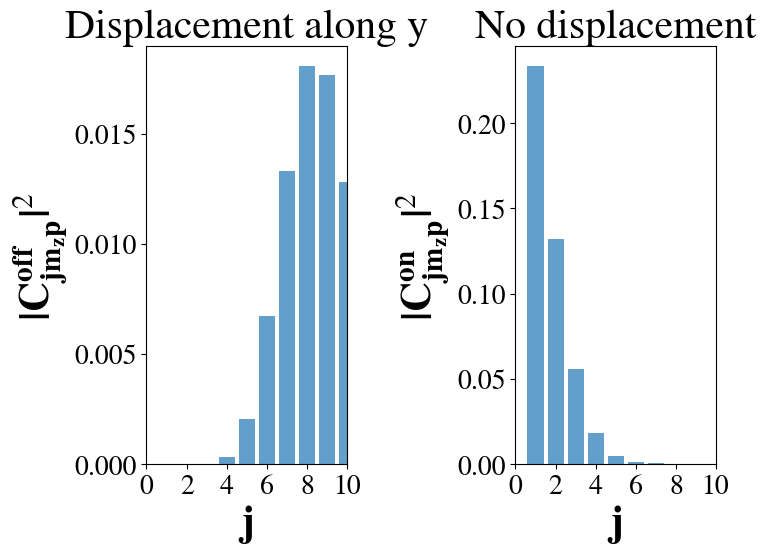

In [1115]:
#plot C_off
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.arange(1, len(C_off)+1), np.sum(C_off,1), alpha=0.7)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_zp}|}^2$", fontsize=30)
ax[0].set_xlabel('j', fontsize=30)
ax[0].set_xlim(0, jmax)
ax[0].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_title("Displacement along y", fontsize=30)
ax[1].bar(np.arange(1, len(C_off)+1), np.abs(foc.C_jlp(l = 0, p = 1, q = 0)[0][1:])**2, alpha=0.7)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=30)
ax[1].set_xlabel('j', fontsize=30)
ax[1].set_xlim(0, jmax)
ax[1].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_title("No displacement", fontsize=30)

fig.tight_layout()
plt.show()

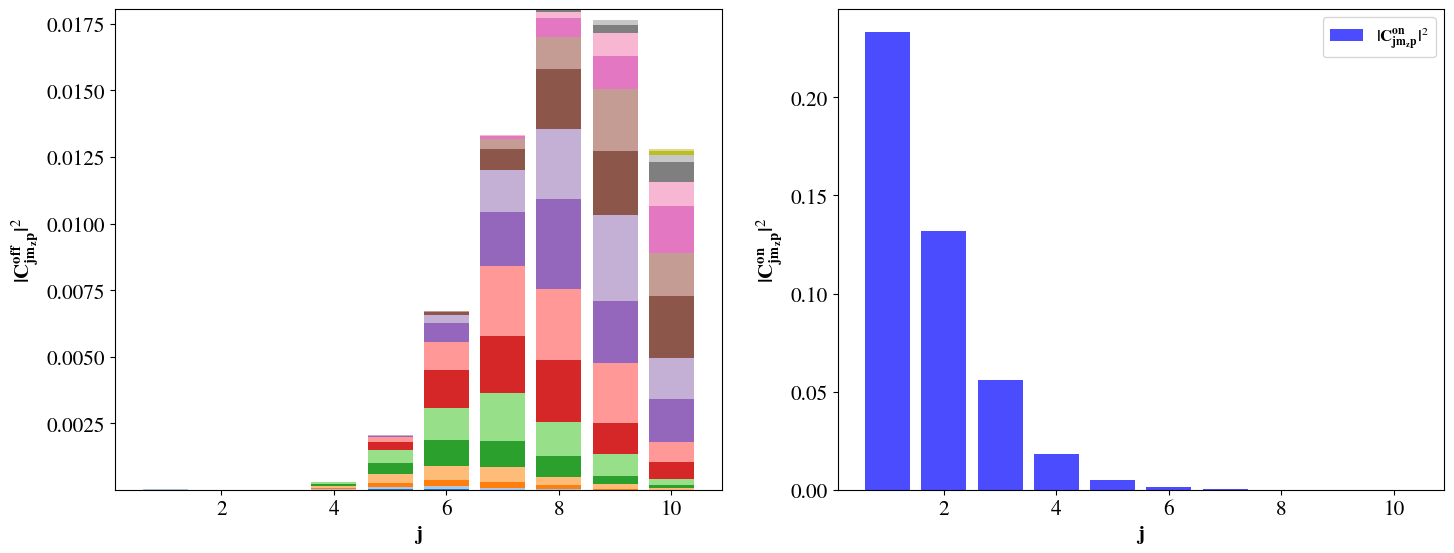

In [ ]:
# Plot stacked histogram and C_on in a (1, 2) subplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Transpose C_off to stack along the rows
C_off_transposed = C_off.T

# Define more distinctive colors using the tab20 colormap
colors = plt.cm.tab20(np.linspace(0, 1, C_off_transposed.shape[0]))

# Create the stacked histogram in the first subplot
ax[0].bar(np.arange(1,C_off_transposed.shape[1]+1),
    C_off_transposed[0],
    color=colors[0]
)
for i in range(1, C_off_transposed.shape[0]):
    ax[0].bar(
        np.arange(1,C_off_transposed.shape[1]+1),
        C_off_transposed[i],
        bottom=np.sum(C_off_transposed[:i], axis=0),
        color=colors[i]
    )

# Add title and axis labels for the first subplot
ax[0].set_xlabel('j', fontsize=15)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_zp}|}^2$", fontsize=15)

# Create the histogram for C_on in the second subplot
ax[1].bar(
    np.arange(1, len(C_on)),
    np.abs(C_on[1:])**2,
    color='blue',
    alpha=0.7,
    label=r"$\mathbf{|C^{on}_{jm_zp}|}^2$"
)

# Add title, axis labels, and legend for the second subplot
ax[1].set_xlabel('j', fontsize=15)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=15)
ax[1].legend(fontsize=12)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()